In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
# Read in vehicles
car_images = glob.glob('cars-jpg/*.jpg')
# Read in non-vehicles
non_car_images = glob.glob('non-car-jpg/*.jpg')        
# Print length of each data set
print(len(car_images) , "car images")
print(len(non_car_images) , "non car images")

6835 car images
6333 non car images


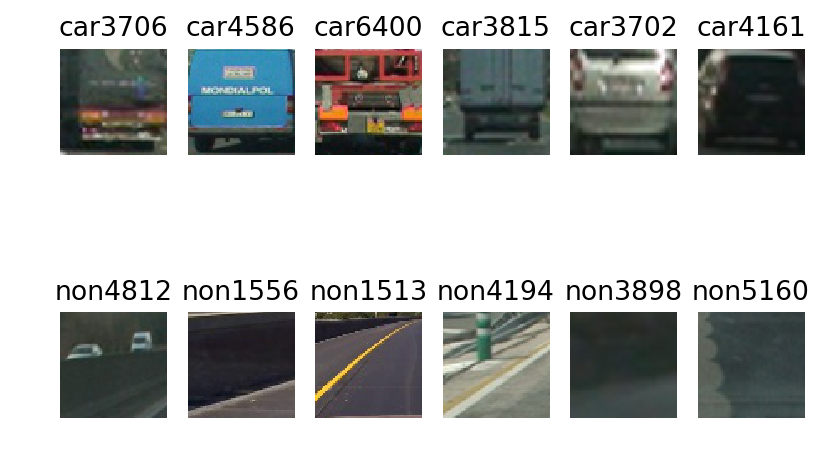

In [3]:
# Display some random samples of cars and non cars
import random
random.seed(11)
%matplotlib inline
f, axarr = plt.subplots(2,6,dpi=160)

for j in range(6):   
    axarr[0,j].axis('off')
    index=random.randint(1,len(car_images))
    img = cv2.cvtColor(cv2.imread(car_images[index]),cv2.COLOR_BGR2RGB)
    axarr[0,j].imshow(img)
    axarr[0,j].set_title("car" + str(index))
    
for j in range(6):   
    axarr[1,j].axis('off')
    index=random.randint(1,len(non_car_images))
    img = cv2.cvtColor(cv2.imread(non_car_images[index]),cv2.COLOR_BGR2RGB)
    axarr[1,j].imshow(img)
    axarr[1,j].set_title("non" + str(index))    
       

In [4]:
# get hog feature function
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=True):
#return features (and image if vis = True)                            
    if vis == True:
        features, image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
        return features, image
    
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
        return features
    


Text(0.5,1,'HOG Visualization')

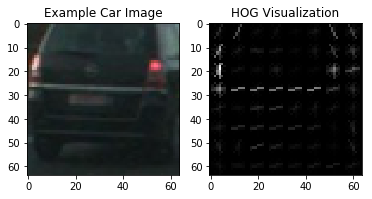

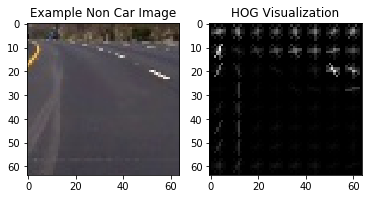

In [5]:
random.seed(5)
# Generate a random index to look at a car image
index = random.randint(0, len(car_images))
# Read in the image
image = cv2.cvtColor(cv2.imread(car_images[index]),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Generate a random index to look at a non car image
index = random.randint(0, len(non_car_images))
# Read in the image
image = cv2.cvtColor(cv2.imread(non_car_images[index]),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

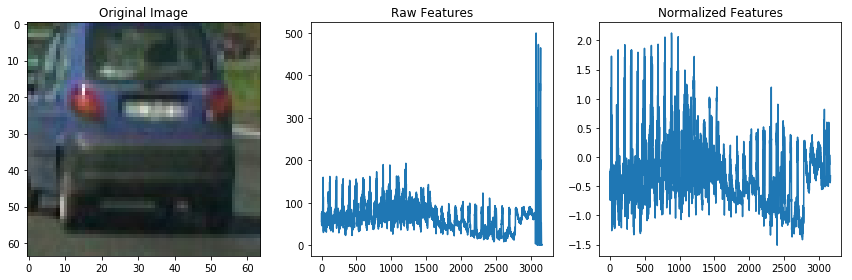

In [6]:

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


        
car_features = extract_features(car_images, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(non_car_images, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(cv2.imread(car_images[car_ind]),cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [7]:
# HOG feature extraction function
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 3:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [8]:
# Divide up into cars and noncars
cars = car_images
notcars = non_car_images

In [9]:
### HOG prameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 16
cell_per_block = 4
hog_channel = 3 # Can be 0, 1, 2, or "ALL (3)"

# Test HOG accuracy and training/predict times
t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
extract_time = (round(t2-t, 2))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
train_time = (round(t2-t, 2))


# Check the prediction time for a single sample
t=time.time()
n_predict = 1000
pd1 = svc.predict(X_test[0:n_predict])
t2 = time.time()
predict_time = round(t2-t, 5)
print(colorspace, "," ,orient, "," , pix_per_cell, "," , cell_per_block, "," , hog_channel, "," , round(svc.score(X_test, y_test), 4), "," , extract_time, "," , train_time, "," , predict_time)

YUV , 12 , 16 , 4 , 3 , 0.9655 , 39.77 , 1.19 , 0.003


In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    view_all_rect = False
    
    rect_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = hog_features.reshape(1,-1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or view_all_rect == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #add rectangles to list to draw all scales at once
                rect_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #return draw_img
    return rect_list
    


In [12]:
def draw_rect_list(full_rect_list,img):
    draw_img = np.copy(img)
    for rect in full_rect_list:
        cv2.rectangle(draw_img,(rect[0]),(rect[1]),(0,0,255),6)
    return draw_img    

In [13]:
def find_cars_all_scales(img):
    X_scaler = 1 #dist_pickle["scaler"]
    spatial_size = (32, 32) #dist_pickle["spatial_size"]
    hist_bins = 32 #dist_pickle["hist_bins"]

    full_rect_list=[]

    ystart = 390
    ystop = 530
    scale = 1.0

    rect_list = (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    for rect in rect_list:
        full_rect_list.append(rect)
        
    ystart = 390
    ystop = 590
    scale = 1.5

    rect_list = (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    for rect in rect_list:
        full_rect_list.append(rect)

    ystart = 380
    ystop = 625
    scale = 2

    rect_list = (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    for rect in rect_list:
        full_rect_list.append(rect)    

    ystart = 400
    ystop = 650
    scale = 3

    rect_list = (find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    for rect in rect_list:
        full_rect_list.append(rect)  
    return full_rect_list    

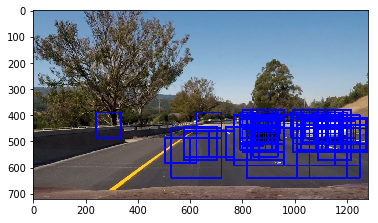

In [14]:
# test find_cars on sample image at a all scales

img = cv2.cvtColor(cv2.imread('./test_images/test6.jpg'),cv2.COLOR_BGR2RGB)

full_rect_list = find_cars_all_scales(img)

out_img = draw_rect_list(full_rect_list, img)

plt.imshow(out_img)

In [15]:
# this was used to capture false positives that were occuring on the yellow lane lines on the left side - this were added to the non car taining data

def save_false(full_rect_list,img,false_num):
    for rect in full_rect_list:
        if rect[0][0]<700:
            if random.randint(0, 1000) > 900:
                false_num = false_num + 1
                wc = img[rect[0][1]:rect[1][1], rect[0][0]:rect[1][0],:]
                resizew = cv2.resize(wc, (64, 64))
                resizewcc = cv2.cvtColor(resizew,cv2.COLOR_BGR2RGB)
                cv2.imwrite("./false/false%d.jpg" % false_num, resizewcc) 
    return false_num

In [16]:
# process video frames with find_cars_all_scales funtion and draw rectangles

false_num = 0

vid_name = "./project_video.mp4"
cap = cv2.VideoCapture(vid_name)
out = cv2.VideoWriter('./pipeline_rect.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))
while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            #out_img = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            full_rect_list = find_cars_all_scales(frame)
            out_img = draw_rect_list(full_rect_list, frame)
            out_cc = cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)
            #false_num = save_false(full_rect_list, frame, false_num)
            cv2.imshow('frame',out_cc)
            out.write(out_cc)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

cap.release()
out.release()
cv2.destroyAllWindows()           

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

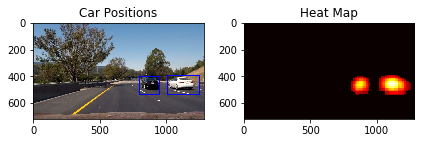

In [20]:
# test heat map on single frame
image = cv2.cvtColor(cv2.imread('./test_images/test6.jpg'),cv2.COLOR_BGR2RGB)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
box_list = find_cars_all_scales(img)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,6)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [21]:
# process video frames with find_cars_all_scales funtion and draw rectangles

false_num = 0

vid_name = "./project_video.mp4"
cap = cv2.VideoCapture(vid_name)
out = cv2.VideoWriter('./final1.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25.0, (1280,720))
heat_list = []
frame_num = 0
while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            frame_num = frame_num + 1
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            heat = np.zeros_like(frame[:,:,0]).astype(np.float)
            box_list = find_cars_all_scales(frame)
            # Add heat to each box in box list
            heat = add_heat(heat,box_list)

            heat_list.append(heat)
            
            if frame_num > 20:
                heat_sum = np.zeros_like(frame[:,:,0]).astype(np.float)
                del heat_list[0]
                for heat_maps in heat_list:
                    heat_sum = heat_sum + heat_maps
                  
                # Apply threshold to help remove false positives
                heat_t = apply_threshold(heat_sum,60.0)
                #print(len(heat_list))
                # Visualize the heatmap when displaying    
                heatmap = np.clip(heat_t, 0, 255)
                
                # Find final boxes from heatmap using label function
                labels = label(heatmap)
                draw_img = draw_labeled_bboxes(np.copy(frame), labels)
            else:
                draw_img = frame
            out_cc = cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)
            
            cv2.imshow('frame',out_cc)
            out.write(out_cc)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

cap.release()
out.release()
cv2.destroyAllWindows()        